In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlalchemy as sa

from scipy.interpolate import griddata
from sqlalchemy import create_engine
from sqlalchemy.engine import URL

# DB Connection
base_connection = "DRIVER={ODBC Driver 17 for SQL Server};SERVER=analityk.wwsi.edu.pl,50221;uid=student;pwd=ciekawski"
air_polution_db = f"{base_connection};DATABASE=Smogoliczka"
connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": air_polution_db})
engine = create_engine(connection_url)

# Fetch Map Points
map_points = None
with engine.begin() as conn:
    map_points_query = "SELECT Kontur.ToString() AS Data, Nazwa FROM KonturyWoj ORDER BY KodTeryt;"
    map_points = pd.read_sql_query(sa.text(map_points_query), conn)

# Fetch Air Polution Data
air_polution = None
with engine.begin() as conn:
    air_polution_query = """
        WITH polution_data AS  (
            SELECT
                YEAR(p.Data) AS Year
                ,DATEPART(quarter, p.Data) AS Quarter
                ,AVG(p.dane) AS Value
                ,rp.NazwaParametru AS Parameter
                ,rp.IdParametru AS ParameterId
                ,LOWER(sp.Wojewodztwo) AS Region
            FROM
                Smogoliczka.dbo.Pomiary AS p
            INNER JOIN Smogoliczka.dbo.RodzajeParametrow AS rp
               ON p.IDRodzaju = rp.IdParametru
            INNER JOIN Smogoliczka.dbo.StacjePomiarowe AS sp
               ON p.IDStacji = sp.IdStacji
            WHERE
                p.status = 1
            GROUP BY
                YEAR(p.Data)
                ,DATEPART(quarter, p.Data)
                ,rp.ParKod
                ,rp.NazwaParametru
                ,rp.IdParametru
                ,LOWER(sp.Wojewodztwo)
        )
        SELECT
            pd.*
            , n.Poziom
        FROM polution_data AS pd
        INNER JOIN Smogoliczka.dbo.Normy AS n
            ON pd.ParameterId = n.IdParametru
            AND pd.Value BETWEEN n.od AND n.do
        ORDER BY pd.Value DESC;
    """
    air_polution = pd.read_sql_query(sa.text(air_polution_query), conn)

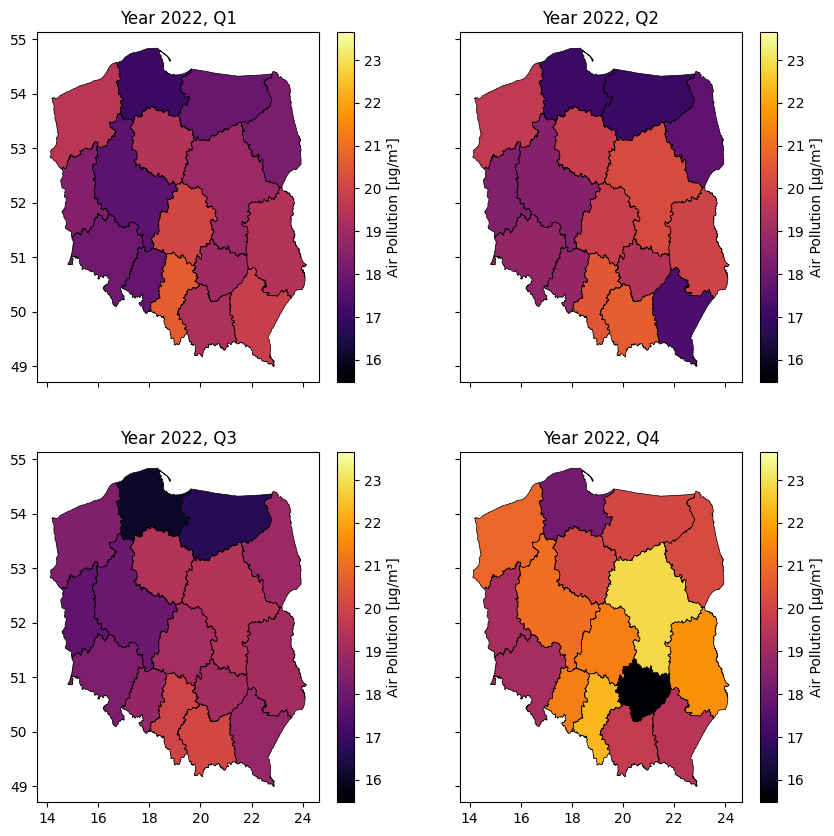

In [27]:
import matplotlib as mpl
from matplotlib.cm import ScalarMappable

# Avg PM Air Polution in each quater 2020
from collections import defaultdict
from matplotlib.colors import Normalize
from shapely.wkt import loads

# Sum Polutions
pm_polution = ["pył zawieszony PM10", "pył zawieszony PM2.5"]
pm_polution_2022 = [x for idx, x in air_polution.iterrows() if x.Year == 2020 and x.Parameter in pm_polution]

# 2020 Year Data
min_polution_10 = min([x["Value"] for x in pm_polution_2022 if x["Parameter"] == pm_polution[0]])
min_polution_25 = min([x["Value"] for x in pm_polution_2022 if x["Parameter"] == pm_polution[1]])
min_polution = min_polution_10 + min_polution_25
max_polution_10 = max([x["Value"] for x in pm_polution_2022 if x["Parameter"] == pm_polution[0]])
max_polution_25 = max([x["Value"] for x in pm_polution_2022 if x["Parameter"] == pm_polution[1]])
max_polution = max_polution_10 + max_polution_25
norm_polution = Normalize(vmin=min_polution, vmax=max_polution)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
cmap = mpl.colormaps['inferno']

for subplot in axes.flat:
    subplot.set(xlabel='', ylabel='')
    subplot.label_outer()

for quarter in range(4):
    # [(q0,q1), (q2, q3)]
    row = 0 if quarter in [0, 1] else 1
    col = 0 if quarter in [0, 2] else 1
    subplot = axes[row, col]
    subplot.set_title("Year 2022, Q{}".format(quarter+1))
    
    for _index, point in map_points.iterrows():
        region = point["Nazwa"]
        geometry = loads(point["Data"])

        quarter_polution = [x for x in pm_polution_2022 if x["Quarter"] == quarter + 1]
        polution_10 = [x for x in quarter_polution if x["Parameter"] == pm_polution[0] and x["Region"] == region]
        polution_25 = [x for x in quarter_polution if x["Parameter"] == pm_polution[1] and x["Region"] == region]
        polution = 0
        for p in polution_10 + polution_25:
            polution += p["Value"]
    
        if geometry.geom_type == 'Polygon':
            x, y = geometry.exterior.xy
            subplot.fill(x, y, color=cmap(norm_polution(polution)), edgecolor='black', linewidth=0.5)
        elif geometry.geom_type == 'MultiPolygon':
            for poly in geometry.geoms:
                x, y = poly.exterior.xy
                subplot.fill(x, y, color=cmap(norm_polution(polution)), edgecolor='black', linewidth=0.5)

    fig.colorbar(ScalarMappable(norm=norm_polution, cmap=cmap), ax=subplot, label="Air Pollution [µg/m³]")